In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
import glob
import struct
import numpy as np
from PIL import Image

### Contents of logical record (2052 bytes)

```
 --------------------------------------------------------------------------------------------
|             |Number|        |                                                              |
|     Byte    |  of  |  Type  |            Contents of Logical Record                        |
|   Position  | Bytes|        |                                                              |
|============================================================================================|
|    1 -    2 |    2 | Integer| Data Number (greater than or equal to 1)                     |
|    3 -    4 |    2 | ASCII  | Character Code ( ex. "0 ", "A ", "$ ", " A", "KA" )          |
|    5 -    6 |    2 | Integer| Serial Sheet Number (greater than or equal to 0)             |
|I   7        |    1 | Binary | JIS Code (JIS X 0201)                                        |
|D   8        |    1 | Binary | EBCDIC Code                                                  |
|    9        |    1 | Integer| Evaluation of Individual Character Image (0=clean, 1, 2, 3)  |
|P  10        |    1 | Integer| Evaluation of Character Group (0=clean, 1, 2)                |
|a  11        |    1 | Integer| Male-Female Code ( 1=male, 2=female ) (JIS X 0303)           |
|r  12        |    1 | Integer| Age of Writer                                                |
|t  13 -   16 |    4 | Integer| Serial Data Number (greater than or equal to 1)              |
|   17 -   18 |    2 | Integer| Industry Classification Code (JIS X 0403)                    |
|   19 -   20 |    2 | Integer| Occupation Classification Code (JIS X 0404)                  |
|   21 -   22 |    2 | Integer| Sheet Gatherring Date (19)YYMM                               |
|   23 -   24 |    2 | Integer| Scanning Date (19)YYMM                                       |
|   25        |    1 | Integer| Sample Position Y on Sheet (greater than or equal to 1)      |
|   26        |    1 | Integer| Sample Position X on Sheet (greater than or equal to 1)      |
|   27        |    1 | Integer| Minimum Scanned Level (0 - 255)                              |
|   28        |    1 | Integer| Maximum Scanned Level (0 - 255)                              |
|   29 -   30 |    2 | Integer| (undefined)                                                  |
|   31 -   32 |    2 | Integer| (undefined)                                                  |
|-------------|------|--------|--------------------------------------------------------------|
|   33 - 2048 | 2016 | Packed | 16 Gray Level (4bit/pixel) Image Data                        |
|             |      |        | 64(X-axis size) * 63(Y-axis size) = 4032 pixels              |
|-------------|------|--------|--------------------------------------------------------------|
| 2049 - 2052 |    4 |        | (uncertain)                                                  |
 --------------------------------------------------------------------------------------------
```

### Functions

In [75]:
def read_ETL_file(f, sample_size, bits_per_pixel, image_shape, unpack_format, image_idx):    
    bytes = f.read(sample_size)
    sample = struct.unpack(unpack_format, bytes)
    
    img = Image.frombytes('F', image_shape, sample[image_idx], 'bit', bits_per_pixel)
    img = img.convert('L')
    img = Image.eval(img, lambda x: (255.0*x)/(2**bits_per_pixel - 1))  # rescale to 0~255 range
    sample += (img,)
    
    return sample


def read_ETL6_data(basepath):
    paths = glob.glob(os.path.join(basepath, 'ETL6C_*'))
    
    sample_size = 2052  # bytes
    bits_per_pixel = 4  # bits
    image_shape = (64, 63)  # pixels
    unpack_format = '>H2sH6BI4H4B2H2016s4x'
    image_idx = 20

    data = []
    for path in paths:
        n_samples = os.stat(path).st_size // sample_size

        with open(path, 'r') as f:
            for i in range(n_samples):
                f.seek(i * sample_size)
                data.append(read_ETL_file(f, sample_size, bits_per_pixel,
                                          image_shape, unpack_format, image_idx))
    
    return data


def data2array(data, new_shape=None, norm_factor=255.0, expand_dims=True):
    
    if new_shape is None:
        images = [np.asarray(d[-1]) for d in data]
    else:
        images = [np.asarray(d[-1].resize(new_shape, Image.BICUBIC)) for d in data]
    
    array = np.stack(images, axis=0)
    
    if norm_factor:
        array = np.float32(array) / norm_factor
    
    if expand_dims:
        array = np.expand_dims(array, axis=3)
    
    labels = np.char.asarray([d[1] for d in data])
    
    return array, labels

### Make array

In [31]:
data = read_ETL6_data('/root/share/personal/data/ETL/ETL6/')

In [76]:
x, y = data2array(data, new_shape=(28, 28))

In [53]:
np.unique(y)

chararray([' A', ' E', ' I', ' N', ' O', ' U', '#', '$S', '$Y', "'", "''", '(',
       '((', '(K', ')', '))', ')K', '*', '+', '++', '+1', ',', ',,', ',0',
       '-', '-6', '.', '.,', '..', '.7', '/', '/0', '/X', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '=', '=(', '=)', '=X', '@', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'HA', 'HE', 'HI', 'HO', 'HU',
       'I', 'J', 'K', 'KA', 'KE', 'KI', 'KO', 'KU', 'L', 'M', 'MA', 'ME',
       'MI', 'MO', 'MU', 'N', 'NA', 'NE', 'NI', 'NO', 'NU', 'O', 'P', 'Q',
       'R', 'RA', 'RE', 'RI', 'RO', 'RU', 'S', 'SA', 'SE', 'SI', 'SO',
       'SU', 'T', 'TA', 'TE', 'TI', 'TO', 'TU', 'U', 'V', 'W', 'WA', 'WO',
       'X', 'Y', 'YA', 'YO', 'YU', 'Z'], 
      dtype='|S2')

In [61]:
katakana = [''.join(e) for e in product(' KSTNHMYRW', 'AIUEO')] + [' N']  # Includes obsolete characters

In [65]:
idx = [i for i, label in enumerate(y) if label in katakana]

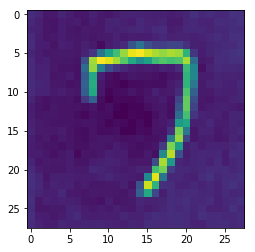

In [83]:
plt.imshow(x[60000,:,:,0])